## Singapore Rainfall data for the location (1.30◦N,103.68◦E), collected in year 2010 from ground-based weather station with high resolution.
---
**AIM** - To understands the relationship between the precipitation estimates from various sensors: ground-based weather stations (PRAT), publicly available weather gauge data, satellite-based, and merged products. The case study is Singapore in our case.

Exploratory analysis - Initial Plotting and Data Parsing.

In [1]:
%matplotlib inline
from glob import glob # For selecting multiple filenames
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.style as style
import xarray as xr
import seaborn as sns # for density plots
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_squared_error
# # Used for DTW
from scipy.spatial.distance import cdist
from tslearn import metrics
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
# from datetime import datetime
style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (16,5) # For Increasing Size of graph
print(f"Xarray Version: {xr.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")

Xarray Version: 0.18.2
Pandas Version: 1.2.4
Numpy Version: 1.18.1


In [3]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Data Importing
---

* For **PRAT - PRivate and Agile Temporally data**, which is the ground based station with high resolution

In [2]:
# Dataframe for PRAT--> PRivate and Agile Temporally data
prat_rainfall_df = pd.read_csv("data/imagerdata.csv", header=None, names=["day", "hour", "minute", "rainfall_rate"])

* For **CHIRPS** - Satellite based public data

In [3]:
chirps_dataset = xr.open_dataset('data/chirps-2010.nc') # open the dataset using xarray

* From **Global Precipitation Measurement (GPM)**

In [4]:
gpm_dataset = xr.open_dataset('data/singaporeIMERG.nc')

* From **Ground based Gauge Station by Meteorological Service Singapore (MSS)**

In [5]:
# Import using glob
filenames = glob("data/daily_*.csv")
gauge_station_df = pd.concat([pd.read_csv(filename, encoding= 'unicode_escape', usecols = ['Year', 'Month', 'Day', 'Daily Rainfall Total (mm)']) 
                              for filename in filenames], axis=0)

gauge_station_df.head()

,Year,Month,Day,Daily Rainfall Total (mm)
0,2010,5,1,0.2
1,2010,5,2,0.0
2,2010,5,3,5.2
3,2010,5,4,7.2
4,2010,5,5,3.8


# Parsing the Datasets

* **Gauge Station**

Parse Year, Month and day. Convert to datetime. Set index to timestamp. Drop Year, Month and Day columns. Rename the column

In [6]:
# Semicolon is used to separate month and day, otherwise datetime is wrongly converted
gauge_station_df['timestamp'] = pd.to_datetime(gauge_station_df['Year'].astype(str) + 
                                               gauge_station_df['Month'].astype(str) + ":"+ 
                                               gauge_station_df['Day'].astype(str), format="%Y%m:%d")

gauge_station_df.set_index('timestamp', inplace=True)
gauge_station_df.drop(['Year', 'Month', 'Day'], inplace=True, axis=1)
gauge_station_df.sort_index(axis=0)
gauge_station_df.rename(columns={'Daily Rainfall Total (mm)':'rainfall_rate'}, inplace=True)

gauge_station_df.head()

,rainfall_rate
timestamp,
2010-05-01,0.2
2010-05-02,0.0
2010-05-03,5.2
2010-05-04,7.2
2010-05-05,3.8


* **CHIRPS**

In [7]:
monsoon_chirps = chirps_dataset.sel(time=slice('2010-06-01','2010-09-30'), 
                                    longitude=103.67499, latitude=1.324997)

* **GPM**

The Dates are not of proper format. So, need to change it to suitable python datetime object

In [8]:
gpm_dataset['time'] = gpm_dataset.indexes['time'].to_datetimeindex()

/Users/dhirajsaharia/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


In [9]:
gpm_sampled = gpm_dataset.sel(lon=103.68, lat=1.30, method='nearest').resample(time='1D').sum()
gpm_sampled

<xarray.Dataset>
Dimensions:           (time: 365)
Coordinates:
  * time              (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31
    lat               float32 1.25
    lon               float32 103.7
Data variables:
    precipitationCal  (time) float32 5.601 0.6215 8.942 ... 0.631 12.4 0.9252

* **PRAT**

In [10]:
# append the timedelta in hours and minutes to get the full timestamp
# Using day number to create the date

prat_rainfall_df['date']=pd.to_datetime(prat_rainfall_df['day'], unit='D', origin=pd.Timestamp('2009-12-31')) 

prat_rainfall_df['timestamp'] = prat_rainfall_df['date'] + pd.to_timedelta(
    prat_rainfall_df['hour'].astype('str') + ':' + 
    prat_rainfall_df['minute'].astype('str') + ':00'
) 
prat_rainfall_df.set_index('timestamp', inplace=True)

In [11]:
prat_sampled_df = pd.DataFrame()
prat_rainfall_df['rainfall_rate'] = prat_rainfall_df['rainfall_rate']/60.0 # mm / 60

# Groupby MONTH and then taking the total daily sum
prat_sampled_df = prat_rainfall_df.resample('D').sum() 

prat_sampled_df.drop(['day', 'hour', 'minute'], axis=1, inplace=True) # Dropped the day, hour, minute columns
prat_sampled_df.head() # PRAT Data after resampling

,rainfall_rate
timestamp,
2010-01-01,18.0
2010-01-02,0.2
2010-01-03,0.2
2010-01-04,13.2
2010-01-05,0.0


# Separate Monsoon Rainfall
---
According to [this](https://www.guidemesingapore.com/business-guides/immigration/get-to-know-singapore/weather-and-climate-in-singapore),
There is no clear-cut wet or dry season and rain is experienced every single month, usually in the afternoons and early evenings. However, there are two main monsoon seasons in Singapore: **Northeast Monsoon Season (December-March) and the Southwest Monsoon Season (June-September)**.

* Extract Monsoon Data

In [12]:
JUNE = 6
SEPT = 9
monsoon_prat = prat_sampled_df[(prat_sampled_df.index.month >= JUNE) & 
                               (prat_sampled_df.index.month <= SEPT)]

monsoon_gauge = gauge_station_df[(gauge_station_df.index.month >= JUNE) & 
                                 (gauge_station_df.index.month <= SEPT)]

monsoon_gauge = monsoon_gauge.sort_index(axis=0)
monsoon_gpm = gpm_sampled.sel(time=slice('2010-06-01','2010-09-30'))

- Extract Non-Monsoon data

In [13]:
non_monsoon_prat = prat_sampled_df[(prat_sampled_df.index.month < JUNE) | 
                               (prat_sampled_df.index.month > SEPT)]

non_monsoon_gauge = gauge_station_df[(gauge_station_df.index.month < JUNE) | 
                                 (gauge_station_df.index.month > SEPT)]
non_monsoon_gauge = non_monsoon_gauge.sort_index(axis=0)

non_monsoon_gpm = gpm_sampled.sel(time=slice('2010-01-01','2010-05-31'))
non_monsoon_gpm = non_monsoon_gpm.merge(gpm_sampled.sel(time=slice('2010-10-01','2010-12-31')))
non_monsoon_gpm

non_monsoon_chirps = chirps_dataset.sel(time=slice('2010-01-01','2010-05-31'), 
                                    longitude=103.67499, latitude=1.324997)
non_monsoon_chirps = non_monsoon_chirps.merge(chirps_dataset.sel(time=slice('2010-10-01','2010-12-31'), 
                                    longitude=103.67499, latitude=1.324997))

- Combine Monsoon and Non-monsoon DF for full year.

In [14]:
full_gpm = gpm_sampled.sel(time=slice('2010-01-01','2010-12-31'))
full_chirps = chirps_dataset.sel(time=slice('2010-01-01','2010-12-31'), 
                                    longitude=103.67499, latitude=1.324997)
full_gauge = gauge_station_df.sort_index(axis=0)
full_prat = prat_sampled_df

* Plot the data (Monsoon Season)

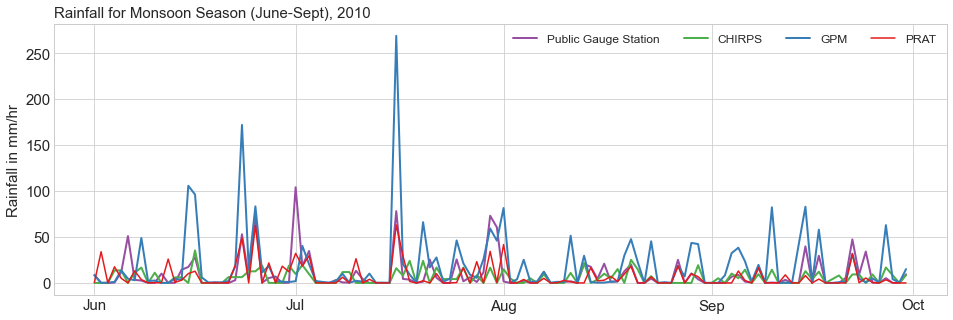

In [16]:
plt.plot(monsoon_gauge['rainfall_rate'], linewidth=2, label='Public Gauge Station', c='#984ea3')
plt.plot(monsoon_chirps['time'], monsoon_chirps['precip'], label='CHIRPS', linewidth=2, c='#4daf4a')
plt.plot(monsoon_gpm['time'], monsoon_gpm['precipitationCal'], linewidth=2, label="GPM", c='#377eb8')
plt.plot(monsoon_prat['rainfall_rate'], label='PRAT', c='#e41a1c')
plt.title('Rainfall for Monsoon Season (June-Sept), 2010', loc='left', fontsize=15)
plt.ylabel("Rainfall in mm/hr", fontsize=15)
ax = plt.gca()
locator = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(month_fmt)
ax.xaxis.label.set_size(50)
plt.legend(loc='upper right', ncol=4, prop={'size': 12}, fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);
# plt.savefig('Figures/monsoon_full.pdf')

- Plot the data (Non-Monsoon Season)

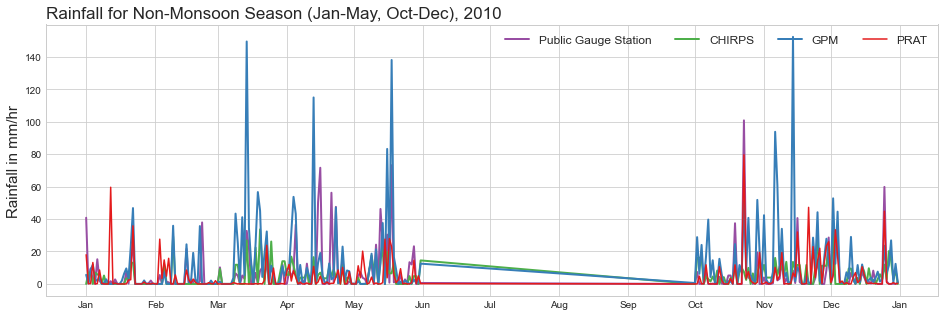

In [17]:
plt.plot(non_monsoon_gauge['rainfall_rate'], linewidth=2, label='Public Gauge Station', c='#984ea3')
plt.plot(non_monsoon_chirps['time'], non_monsoon_chirps['precip'], label='CHIRPS', linewidth=2, c='#4daf4a')
plt.plot(non_monsoon_gpm['time'], non_monsoon_gpm['precipitationCal'], linewidth=2, label="GPM", c='#377eb8')
plt.plot(non_monsoon_prat['rainfall_rate'], label='PRAT', c='#e41a1c')
plt.title('Rainfall for Non-Monsoon Season (Jan-May, Oct-Dec), 2010', loc='left', fontsize=17)
plt.ylabel("Rainfall in mm/hr", fontsize=15)
ax = plt.gca()
locator = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(month_fmt)
plt.legend(loc='upper right', ncol=4, prop={'size': 12}, fontsize=16);
# plt.savefig('Figures/non_monsoon_full.pdf')

* Distribution Plot

/Users/dhirajsaharia/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/dhirajsaharia/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/dhirajsaharia/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

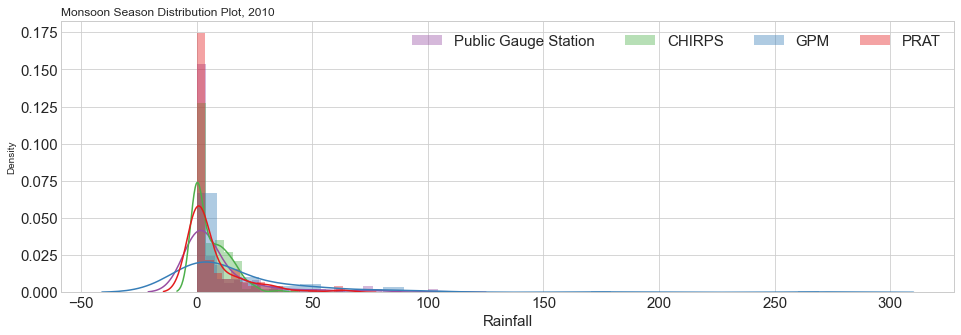

In [19]:
sns.distplot(monsoon_gauge['rainfall_rate'], hist=True, kde=True, label='Public Gauge Station', color='#984ea3')
sns.distplot(monsoon_chirps['precip'], hist=True, kde=True, label='CHIRPS', color='#4daf4a')
sns.distplot(monsoon_gpm['precipitationCal'], hist=True, kde=True, label='GPM', color='#377eb8')
sns.distplot(monsoon_prat['rainfall_rate'], hist=True, kde=True, label='PRAT', color='#e41a1c')
plt.legend(fontsize=15, ncol=4)
plt.title('Monsoon Season Distribution Plot, 2010', loc="left", )
plt.xlabel("Rainfall", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);
#plt.savefig('Figures/monsoon_distribution.pdf');

# Correlation Calculation
---
## Pearson Coefficient (PCC)

In [29]:
def print_pcc(a, b, name_a, name_b):
    """
    This funciton takes two Series, computes and displays the PCC value.
    """
    pcc = round(a.corr(b), 2)
    print(f"PCC of {name_a} with {name_b}: {pcc}")

In [30]:
print("====== PRAT Vs Other =====")
print("---- Monsoon Season PCC ----")
print_pcc(monsoon_prat['rainfall_rate'], monsoon_gauge['rainfall_rate'], "PRAT", "GAUGE")
print_pcc(monsoon_prat['rainfall_rate'], monsoon_gpm['precipitationCal'].to_series(), "PRAT", "GPM")
print_pcc(monsoon_prat['rainfall_rate'], monsoon_chirps['precip'].to_series(), "PRAT", "CHIRPS")
print("---- Non-Monsoon Season PCC ----")
print_pcc(non_monsoon_prat['rainfall_rate'], non_monsoon_gauge['rainfall_rate'], "PRAT", "GAUGE")
print_pcc(non_monsoon_prat['rainfall_rate'], non_monsoon_gpm['precipitationCal'].to_series(), "PRAT", "GPM")
print_pcc(non_monsoon_prat['rainfall_rate'], non_monsoon_chirps['precip'].to_series(), "PRAT", "CHIRPS")
print("---- Full Year PCC ----")
print_pcc(full_prat['rainfall_rate'], full_gauge['rainfall_rate'], "PRAT", "GAUGE")
print_pcc(full_prat['rainfall_rate'], full_gpm['precipitationCal'].to_series(), "PRAT", "GPM")
print_pcc(full_prat['rainfall_rate'], full_chirps['precip'].to_series(), "PRAT", "CHIRPS")

====== PRAT Vs Other =====
---- Monsoon Season PCC ----
PCC of PRAT with GAUGE: 0.62
PCC of PRAT with GPM: 0.59
PCC of PRAT with CHIRPS: 0.27
---- Non-Monsoon Season PCC ----
PCC of PRAT with GAUGE: 0.47
PCC of PRAT with GPM: 0.21
PCC of PRAT with CHIRPS: 0.11
---- Full Year PCC ----
PCC of PRAT with GAUGE: 0.54
PCC of PRAT with GPM: 0.41
PCC of PRAT with CHIRPS: 0.18


In [31]:
print("====== GAUGE Vs Other =====")
print("---- Monsoon Season PCC ----")
print_pcc(monsoon_gauge['rainfall_rate'], monsoon_prat['rainfall_rate'], "GAUGE", "PRAT")
print_pcc(monsoon_gauge['rainfall_rate'], monsoon_gpm['precipitationCal'].to_series(), "GAUGE", "GPM")
print_pcc(monsoon_gauge['rainfall_rate'], monsoon_chirps['precip'].to_series(), "GAUGE", "CHIRPS")
print("---- Non-Monsoon Season PCC ----")
print_pcc(non_monsoon_gauge['rainfall_rate'], non_monsoon_prat['rainfall_rate'], "GAUGE", "PRAT")
print_pcc(non_monsoon_gauge['rainfall_rate'], non_monsoon_gpm['precipitationCal'].to_series(), "GAUGE", "GPM")
print_pcc(non_monsoon_gauge['rainfall_rate'], non_monsoon_chirps['precip'].to_series(), "GAUGE", "CHIRPS")
print("---- Full Year PCC ----")
print_pcc(full_gauge['rainfall_rate'], full_prat['rainfall_rate'], "GAUGE", "PRAT")
print_pcc(full_gauge['rainfall_rate'], full_gpm['precipitationCal'].to_series(), "GAUGE", "GPM")
print_pcc(full_gauge['rainfall_rate'], full_chirps['precip'].to_series(), "GAUGE", "CHIRPS")

====== GAUGE Vs Other =====
---- Monsoon Season PCC ----
PCC of GAUGE with PRAT: 0.62
PCC of GAUGE with GPM: 0.54
PCC of GAUGE with CHIRPS: 0.23
---- Non-Monsoon Season PCC ----
PCC of GAUGE with PRAT: 0.47
PCC of GAUGE with GPM: 0.44
PCC of GAUGE with CHIRPS: 0.25
---- Full Year PCC ----
PCC of GAUGE with PRAT: 0.54
PCC of GAUGE with GPM: 0.5
PCC of GAUGE with CHIRPS: 0.25


In [32]:
print("====== CHIRPS Vs Other =====")
print("---- Monsoon Season PCC ----")
print_pcc(monsoon_chirps['precip'].to_series(), monsoon_prat['rainfall_rate'], "CHIRPS", "PRAT")
print_pcc(monsoon_chirps['precip'].to_series(), monsoon_gpm['precipitationCal'].to_series(), "CHIRPS", "GPM")
print_pcc(monsoon_chirps['precip'].to_series(), monsoon_gauge['rainfall_rate'], "CHIRPS", "GAUGE")
print("---- Non-Monsoon Season PCC ----")
print_pcc(non_monsoon_chirps['precip'].to_series(), non_monsoon_prat['rainfall_rate'], "CHIRPS", "PRAT")
print_pcc(non_monsoon_chirps['precip'].to_series(), non_monsoon_gpm['precipitationCal'].to_series(), "CHIRPS", "GPM")
print_pcc(non_monsoon_chirps['precip'].to_series(), non_monsoon_gauge['rainfall_rate'], "CHIRPS", "GAUGE")
print("---- Full Year PCC ----")
print_pcc(full_chirps['precip'].to_series(), full_prat['rainfall_rate'], "CHIRPS", "PRAT")
print_pcc(full_chirps['precip'].to_series(), full_gpm['precipitationCal'].to_series(), "CHIRPS", "GPM")
print_pcc(full_chirps['precip'].to_series(), full_gauge['rainfall_rate'], "CHIRPS", "GAUGE")

====== CHIRPS Vs Other =====
---- Monsoon Season PCC ----
PCC of CHIRPS with PRAT: 0.27
PCC of CHIRPS with GPM: 0.43
PCC of CHIRPS with GAUGE: 0.23
---- Non-Monsoon Season PCC ----
PCC of CHIRPS with PRAT: 0.11
PCC of CHIRPS with GPM: 0.51
PCC of CHIRPS with GAUGE: 0.25
---- Full Year PCC ----
PCC of CHIRPS with PRAT: 0.18
PCC of CHIRPS with GPM: 0.47
PCC of CHIRPS with GAUGE: 0.25


In [33]:
print("====== GPM Vs Other =====")
print("---- Monsoon Season PCC ----")
print_pcc(monsoon_gpm['precipitationCal'].to_series(), monsoon_prat['rainfall_rate'], "GPM", "PRAT")
print_pcc(monsoon_gpm['precipitationCal'].to_series(), monsoon_chirps['precip'].to_series(), "GPM", "CHIRPS")
print_pcc(monsoon_gpm['precipitationCal'].to_series(), monsoon_gauge['rainfall_rate'], "GPM", "GAUGE")
print("---- Non-Monsoon Season PCC ----")
print_pcc(non_monsoon_gpm['precipitationCal'].to_series(), non_monsoon_prat['rainfall_rate'], "GPM", "PRAT")
print_pcc(non_monsoon_gpm['precipitationCal'].to_series(), non_monsoon_chirps['precip'].to_series(), "GPM", "CHIRPS")
print_pcc(non_monsoon_gpm['precipitationCal'].to_series(), non_monsoon_gauge['rainfall_rate'], "GPM", "GAUGE")
print("---- Full Year PCC ----")
print_pcc(full_gpm['precipitationCal'].to_series(), full_prat['rainfall_rate'], "GPM", "PRAT")
print_pcc(full_gpm['precipitationCal'].to_series(), full_chirps['precip'].to_series(), "GPM", "CHIRPS")
print_pcc(full_gpm['precipitationCal'].to_series(), full_gauge['rainfall_rate'], "GPM", "GAUGE")

====== GPM Vs Other =====
---- Monsoon Season PCC ----
PCC of GPM with PRAT: 0.59
PCC of GPM with CHIRPS: 0.43
PCC of GPM with GAUGE: 0.54
---- Non-Monsoon Season PCC ----
PCC of GPM with PRAT: 0.21
PCC of GPM with CHIRPS: 0.51
PCC of GPM with GAUGE: 0.44
---- Full Year PCC ----
PCC of GPM with PRAT: 0.41
PCC of GPM with CHIRPS: 0.47
PCC of GPM with GAUGE: 0.5


## Kling-Gupta Efficiency

In the computation of this index, there are three main components involved:

1) r : the Pearson product-moment correlation coefficient. Ideal value is r=1

2) Beta : the ratio between the mean of the simulated values and the mean of the observed ones. Ideal value is Beta=1

3) vr : variability ratio, which could be computed using the standard deviation (Alpha) or the coefficient of variation (Gamma) of sim and obs, depending on the value of method

3.1) Alpha: the ratio between the standard deviation of the simulated values and the standard deviation of the observed ones. Ideal value is Alpha=1.

3.2) Gamma: the ratio between the coefficient of variation (CV) of the simulated values to the coefficient of variation of the observed ones. Ideal value is Gamma=1. 

In [ ]:
def kge(simulated, observed):
    cc = np.corrcoef(simulated, observed)[0, 1]
    alpha = np.std(observed) / np.std(simulated)
    beta = np.sum(observed) / np.sum(simulated)
    kge = 1 - np.sqrt((cc - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    return kge

In [ ]:
kge_gauge_monsoon = kge(monsoon_gauge['rainfall_rate'], monsoon_prat['rainfall_rate'])
kge_chirps_monsoon = kge(monsoon_chirps['precip'].to_series(), monsoon_prat['rainfall_rate'])
kge_gpm_monsoon = kge(monsoon_gpm['precipitationCal'].to_series(), monsoon_prat['rainfall_rate'])
print("--- Monsoon Season ---")
print(f"KGE Scores of PRAT with \n Gauge : {kge_gauge_monsoon} \n CHIRPS : {kge_chirps_monsoon} \n GPM : {kge_gpm_monsoon}")

In [ ]:
print("--- Non-Monsoon Season ---")
kge_gauge_non = kge(non_monsoon_gauge['rainfall_rate'], non_monsoon_prat['rainfall_rate'])
kge_chirps_non = kge(non_monsoon_chirps['precip'].to_series(), non_monsoon_prat['rainfall_rate'])
kge_gpm_non = kge(non_monsoon_gpm['precipitationCal'].to_series(), non_monsoon_prat['rainfall_rate'])
print(f"KGE Scores of PRAT with \n Gauge : {kge_gauge_non} \n CHIRPS : {kge_chirps_non} \n GPM : {kge_gpm_non}")

In [ ]:
print("--- Yearly ---")
kge_gauge_full = kge(full_gauge['rainfall_rate'], full_prat['rainfall_rate'])
kge_chirps_full = kge(full_chirps['precip'].to_series(), full_prat['rainfall_rate'])
kge_gpm_full = kge(full_gpm['precipitationCal'].to_series(), full_prat['rainfall_rate'])
print(f"KGE Scores of PRAT with \n Gauge : {kge_gauge_full} \n CHIRPS : {kge_chirps_full} \n GPM : {kge_gpm_full}")

* Monthly Correlation values for whole year

Calculate the monsoon and non-monsoon correlation values, then merge them to form the year correlation value set.
### Note -
When plotting the bar graph for the correlation values, a bug was identified when the x-axis month labels were miscategorized, i.e the `Jan` tick went to the last bar. This was asked on StackOverflow [Here](https://stackoverflow.com/questions/63307864/why-month-x-ticks-are-labelled-wrongly-in-a-datetime-index/63313146#63313146). The cause was since the month dates were closer to the next months dates, so the bar graph was overlaying it. The solution was to modify the datetime index.

In [ ]:
monsoon_corr = pd.merge(
    monsoon_prat, monsoon_gauge, 
    on='timestamp'
).resample('1M')[['rainfall_rate_x', 'rainfall_rate_y']].corr().groupby(level=0).first()
monsoon_corr.drop('rainfall_rate_x', axis=1, inplace=True)
non_monsoon_corr = pd.merge(
    non_monsoon_prat, 
    non_monsoon_gauge, 
    on='timestamp'
).resample('1M')[['rainfall_rate_x', 'rainfall_rate_y']].corr().groupby(level=0).first()
non_monsoon_corr.drop(
    [pd.to_datetime('2010-06-30'), pd.to_datetime('2010-07-31'), 
     pd.to_datetime('2010-08-31'), pd.to_datetime('2010-09-30')], inplace=True
)
non_monsoon_corr.drop('rainfall_rate_x', axis=1, inplace=True)
full_corr = pd.concat([non_monsoon_corr, monsoon_corr])
full_corr.sort_index(axis=0, inplace=True)
full_corr.rename(columns={'rainfall_rate_y':'corr'}, inplace=True)
# Creating a new index using the month and year only.
full_corr['new_timestamp'] = full_corr.index.map(lambda x: datetime.datetime.strftime(x, '%Y-%m'))
full_corr['new_timestamp'] = pd.to_datetime(full_corr['new_timestamp'])
# Setting this as the new index
full_corr.set_index('new_timestamp', inplace=True)
# Plot
plt.bar(full_corr.index, full_corr['corr'], width=12) # some bugs are there
plt.title("Pearson Correlation Coefficient (PCC) of PRAT with Gauge Station, 2010", loc="left", fontsize=15)
plt.ylabel("PCC value", fontsize=15)
ax = plt.gca()
locator = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(month_fmt)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);
# plt.savefig('Figures/year_PCC.pdf');

In [ ]:
full_corr

## Error Metrics Calculation - MSE and RMSE

In [17]:
def print_mse_rmse(a, b, c, d):
    """
    This function
    """
    mse_b = mean_squared_error(a, b)
    mse_c = mean_squared_error(a, c)
    mse_d = mean_squared_error(a, d)
    
    rmse_b = mean_squared_error(a, b, squared=False)
    rmse_c = mean_squared_error(a, c, squared=False)
    rmse_d = mean_squared_error(a, d, squared=False)
    
    print(f"{'MSE - ':>7s}{mse_b:>7.2f}{' '*3}{mse_c:>7.2f}{' '*3}{mse_d:>7.2f}")
    print(f"{'RMSE - ':>7s}{rmse_b:>7.2f}{' '*3}{rmse_c:>7.2f}{' '*3}{rmse_d:>7.2f}")

In [53]:
# mse_gauge_monsoon = mean_squared_error(monsoon_prat['rainfall_rate'], monsoon_gauge['rainfall_rate'])
# mse_chirps_monsoon = mean_squared_error(monsoon_prat['rainfall_rate'], monsoon_chirps['precip'])
# mse_gpm_monsoon = mean_squared_error(monsoon_prat['rainfall_rate'], monsoon_gpm['precipitationCal'])

# rmse_gauge_monsoon = mean_squared_error(monsoon_prat['rainfall_rate'], monsoon_gauge['rainfall_rate'], squared=False)
# rmse_chirps_monsoon = mean_squared_error(monsoon_prat['rainfall_rate'], monsoon_chirps['precip'], squared=False)
# rmse_gpm_monsoon = mean_squared_error(monsoon_prat['rainfall_rate'], monsoon_gpm['precipitationCal'], squared=False)

# mse_gauge_non = mean_squared_error(non_monsoon_prat['rainfall_rate'], non_monsoon_gauge['rainfall_rate'])
# mse_chirps_non = mean_squared_error(non_monsoon_prat['rainfall_rate'], non_monsoon_chirps['precip'])
# mse_gpm_non = mean_squared_error(non_monsoon_prat['rainfall_rate'], non_monsoon_gpm['precipitationCal'])

# rmse_gauge_non = mean_squared_error(non_monsoon_prat['rainfall_rate'], non_monsoon_gauge['rainfall_rate'], squared=False)
# rmse_chirps_non = mean_squared_error(non_monsoon_prat['rainfall_rate'], non_monsoon_chirps['precip'], squared=False)
# rmse_gpm_non = mean_squared_error(non_monsoon_prat['rainfall_rate'], non_monsoon_gpm['precipitationCal'], squared=False)

In [18]:
print("===== PRAT Vs OTHER =====")
print("--- Monsoon Season ---")
print(f"{' ':>7s}{'GAUGE':>7s}{' '*3}{'CHIRPS':>7s}{' '*3}{'GPM':>7s}")
print_mse_rmse(monsoon_prat['rainfall_rate'], monsoon_gauge['rainfall_rate'], 
               monsoon_chirps['precip'], monsoon_gpm['precipitationCal'])
print("--- Non-Monsoon Season ---")
print_mse_rmse(non_monsoon_prat['rainfall_rate'], non_monsoon_gauge['rainfall_rate'], 
               non_monsoon_chirps['precip'], non_monsoon_gpm['precipitationCal'])

===== PRAT Vs OTHER =====
--- Monsoon Season ---
         GAUGE    CHIRPS       GPM
 MSE -  212.27    160.23   1040.85
RMSE -   14.57     12.66     32.26
--- Non-Monsoon Season ---
 MSE -  157.00    130.78    566.58
RMSE -   12.53     11.44     23.80


In [19]:
print("===== GAUGE Vs OTHER =====")
print("--- Monsoon Season ---")
print(f"{' ':>7s}{'PRAT':>7s}{' '*3}{'CHIRPS':>7s}{' '*3}{'GPM':>7s}")
print_mse_rmse(monsoon_gauge['rainfall_rate'], monsoon_prat['rainfall_rate'], 
               monsoon_chirps['precip'], monsoon_gpm['precipitationCal'])
print("--- Non - Monsoon Season ---")
print_mse_rmse(non_monsoon_gauge['rainfall_rate'], non_monsoon_prat['rainfall_rate'], 
               non_monsoon_chirps['precip'], non_monsoon_gpm['precipitationCal'])

===== GAUGE Vs OTHER =====
--- Monsoon Season ---
          PRAT    CHIRPS       GPM
 MSE -  212.27    336.02    988.58
RMSE -   14.57     18.33     31.44
--- Non - Monsoon Season ---
 MSE -  157.00    184.92    452.07
RMSE -   12.53     13.60     21.26


In [20]:
print("===== CHIRPS Vs OTHER =====")
print("--- Monsoon Season ---")
print(f"{' ':>7s}{'PRAT':>7s}{' '*3}{'GAUGE':>7s}{' '*3}{'GPM':>7s}")
print_mse_rmse(monsoon_chirps['precip'], monsoon_prat['rainfall_rate'], monsoon_gauge['rainfall_rate'],
               monsoon_gpm['precipitationCal'])
print("--- Non - Monsoon Season ---")
print_mse_rmse(non_monsoon_chirps['precip'], non_monsoon_prat['rainfall_rate'], non_monsoon_gauge['rainfall_rate'],
               non_monsoon_gpm['precipitationCal'])

===== CHIRPS Vs OTHER =====
--- Monsoon Season ---
          PRAT     GAUGE       GPM
 MSE -  160.23    336.02   1267.98
RMSE -   12.66     18.33     35.61
--- Non - Monsoon Season ---
 MSE -  130.78    184.92    441.86
RMSE -   11.44     13.60     21.02


In [21]:
print("===== GPM Vs OTHER =====")
print("--- Monsoon Season ---")
print(f"{' ':>7s}{'PRAT':>7s}{' '*3}{'GAUGE':>7s}{' '*3}{'CHIRPS':>7s}")
print_mse_rmse(monsoon_gpm['precipitationCal'], monsoon_prat['rainfall_rate'], monsoon_gauge['rainfall_rate'],
               monsoon_chirps['precip'])
print("--- Non - Monsoon Season ---")
print_mse_rmse(non_monsoon_gpm['precipitationCal'], non_monsoon_prat['rainfall_rate'], non_monsoon_gauge['rainfall_rate'],
               non_monsoon_chirps['precip'])

===== GPM Vs OTHER =====
--- Monsoon Season ---
          PRAT     GAUGE    CHIRPS
 MSE - 1040.85    988.58   1267.98
RMSE -   32.26     31.44     35.61
--- Non - Monsoon Season ---
 MSE -  566.58    452.07    441.86
RMSE -   23.80     21.26     21.02


In [47]:
# print("===== PRAT Vs OTHER =====")
# print("--- Monsoon Season ---")
# print(f"{' ':>7s}{'GAUGE':>7s}{' '*3}{'CHIRPS':>7s}{' '*3}{'GPM':>7s}")
# print(f"{'MSE - ':>7s}{mse_gauge_monsoon:>7.2f}{' '*3}{mse_chirps_monsoon:>7.2f}{' '*3}{mse_gpm_monsoon:>7.2f}")
# print(f"{'RMSE - ':>7s}{rmse_gauge_monsoon:>7.2f}{' '*3}{rmse_chirps_monsoon:>7.2f}{' '*3}{rmse_gpm_monsoon:>7.2f}")
# print("--- Non-Monsoon Season ---")
# print(f"{'MSE - ':>7s}{mse_gauge_non:>7.2f}{' '*3}{mse_chirps_non:>7.2f}{' '*3}{mse_gpm_non:>7.2f}")
# print(f"{'RMSE - ':>7s}{rmse_gauge_non:>7.2f}{' '*3}{rmse_chirps_non:>7.2f}{' '*3}{rmse_gpm_non:>7.2f}")

In [35]:
# g_mse_prat_mon, g_rmse_prat_mon = compute_mse_rmse(monsoon_gauge['rainfall_rate'], monsoon_prat['rainfall_rate'])
# g_mse_chirps_mon, g_rmse_chirps_mon = compute_mse_rmse(monsoon_gauge['rainfall_rate'], monsoon_chirps['precip'])
# g_mse_gpm_mon, g_rmse_gpm_mon = compute_mse_rmse(monsoon_gauge['rainfall_rate'], monsoon_gpm['precipitationCal'])

# g_mse_prat_non, g_rmse_prat_non = compute_mse_rmse(non_monsoon_gauge['rainfall_rate'], 
#                                                    non_monsoon_prat['rainfall_rate'])
# g_mse_chirps_non, g_rmse_chirps_non = compute_mse_rmse(non_monsoon_gauge['rainfall_rate'], 
#                                                        non_monsoon_chirps['precip'])
# g_mse_gpm_non, g_rmse_gpm_non = compute_mse_rmse(non_monsoon_gauge['rainfall_rate'], 
#                                                  non_monsoon_gpm['precipitationCal'])

In [37]:
print("===== GAUGE Vs OTHER =====")
print("--- Monsoon Season ---")
print(f"{' ':>7s}{'PRAT':>7s}{' '*3}{'CHIRPS':>7s}{' '*3}{'GPM':>7s}")
print(f"{'MSE - ':>7s}{g_mse_prat_mon:>7.2f}{' '*3}{g_mse_chirps_mon:>7.2f}{' '*3}{g_mse_gpm_mon:>7.2f}")
print(f"{'RMSE - ':>7s}{g_rmse_prat_mon:>7.2f}{' '*3}{g_rmse_chirps_mon:>7.2f}{' '*3}{g_rmse_gpm_mon:>7.2f}")
print("--- Non - Monsoon Season ---")
print(f"{'MSE - ':>7s}{g_mse_prat_non:>7.2f}{' '*3}{g_mse_chirps_non:>7.2f}{' '*3}{g_mse_gpm_non:>7.2f}")
print(f"{'RMSE - ':>7s}{g_rmse_prat_non:>7.2f}{' '*3}{g_rmse_chirps_non:>7.2f}{' '*3}{g_rmse_gpm_non:>7.2f}")

===== GAUGE Vs OTHER =====
--- Monsoon Season ---
          PRAT    CHIRPS       GPM
 MSE -  212.27    336.02    988.58
RMSE -   14.57     18.33     31.44
--- Non - Monsoon Season ---
 MSE -  157.00    184.92    452.07
RMSE -   12.53     13.60     21.26


# Scatter Plots of PRAT with other datasets
---

In [ ]:
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.suptitle("Scatter Plot for Monsoon season", fontsize=15)
plt.scatter(monsoon_gauge['rainfall_rate'], monsoon_prat['rainfall_rate'], alpha=0.6)
plt.xlabel('Gauge Station', fontsize=15)
plt.ylabel('PRAT', fontsize=15)
plt.subplot(1,3,2)
plt.scatter(monsoon_gpm['precipitationCal'], monsoon_prat['rainfall_rate'], alpha=0.6)
plt.xlabel('GPM', fontsize=15)
plt.subplot(1,3,3)
plt.scatter(monsoon_chirps['precip'], monsoon_prat['rainfall_rate'], alpha=0.6)
plt.xlabel('CHIRPS', fontsize=15)
# plt.savefig('Figures/monsoon_scatter.pdf');

In [ ]:
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.suptitle("Scatter Plot for Non-Monsoon season", fontsize=15)
plt.scatter(non_monsoon_gauge['rainfall_rate'], non_monsoon_prat['rainfall_rate'], alpha=0.35)
plt.xlabel('Gauge Station', fontsize=15)
plt.ylabel('PRAT', fontsize=15)
plt.subplot(1,3,2)
plt.scatter(non_monsoon_gpm['precipitationCal'], non_monsoon_prat['rainfall_rate'], alpha=0.35)
plt.xlabel('GPM', fontsize=15)
plt.subplot(1,3,3)
plt.scatter(non_monsoon_chirps['precip'], non_monsoon_prat['rainfall_rate'], alpha=0.35)
plt.xlabel('CHIRPS', fontsize=15);
# plt.savefig('Figures/non_monsoon_scatter.pdf');

# Dynamic Time Warping (DTW) -
---
To be checked later

In [ ]:
# scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
# prat_scaled = scaler.fit_transform(monsoon_prat['rainfall_rate'])
# gauge_scaled = scaler.fit_transform(monsoon_gauge['rainfall_rate'])
path_gauge_monsoon, sim_gauge_monsoon = metrics.dtw_path(monsoon_prat['rainfall_rate'], monsoon_gauge['rainfall_rate'])
path_gpm_monsoon, sim_gpm_monsoon = metrics.dtw_path(monsoon_prat['rainfall_rate'], monsoon_gpm['precipitationCal'])
path_chirps_monsoon, sim_chirps_monsoon = metrics.dtw_path(monsoon_prat['rainfall_rate'], monsoon_chirps['precip'])
print("--- Monsoon Season ---")
print(f"DTW similarity score between PRAT and gauge station is {sim_gauge_monsoon:.3f}")
print(f"DTW similarity score between PRAT and GPM is {sim_gpm_monsoon:.3f}")
print(f"DTW similarity score between PRAT and CHIRPS is {sim_chirps_monsoon:.3f}")

path_gauge, sim_gauge_non_mon = metrics.dtw_path(non_monsoon_prat['rainfall_rate'], non_monsoon_gauge['rainfall_rate'])
path_gpm, sim_gpm_non_mon = metrics.dtw_path(non_monsoon_prat['rainfall_rate'], non_monsoon_gpm['precipitationCal'])
path_chirps, sim_chirps_non_mon = metrics.dtw_path(non_monsoon_prat['rainfall_rate'], non_monsoon_chirps['precip'])
print("--- Non-Monsoon Season ---")
print(f"PRAT and gauge station: {sim_gauge_non_mon:.3f}")
print(f"PRAT and GPM: {sim_gpm_non_mon:.3f}")
print(f"PRAT and CHIRPS: {sim_chirps_non_mon:.3f}")

path_gauge, sim_gauge_full = metrics.dtw_path(full_prat['rainfall_rate'], full_gauge['rainfall_rate'])
path_gpm, sim_gpm_full = metrics.dtw_path(full_prat['rainfall_rate'], full_gpm['precipitationCal'])
path_chirps, sim_chirps_full = metrics.dtw_path(full_prat['rainfall_rate'], full_chirps['precip'])
print("--- Full year ---")
print(f"PRAT and gauge station: {sim_gauge_full:.3f}")
print(f"PRAT and GPM: {sim_gpm_full:.3f}")
print(f"PRAT and CHIRPS: {sim_chirps_full:.3f}")

In [ ]:
def plot_DTW(series, path, labels, color):
    left, bottom = 0.01, 0.1
    w_ts = h_ts = 0.2
    left_h = left + w_ts + 0.02
    width = height = 0.65
    bottom_h = bottom + height + 0.02

    rect_s_y = [left, bottom, w_ts, height]
    rect_gram = [left_h, bottom, width, height]
    rect_s_x = [left_h, bottom_h, width, h_ts]
    
    plt.figure(1, figsize=(8, 8))
    ax_gram = plt.axes(rect_gram)
    ax_s_x = plt.axes(rect_s_x)
    ax_s_y = plt.axes(rect_s_y)
    sz =  monsoon_prat['rainfall_rate'].shape[0]
    distance = cdist(
        monsoon_prat['rainfall_rate'].to_numpy().reshape(-1, 1),
        series.reshape(-1, 1)
    )
    ax_gram.imshow(distance, origin='lower', cmap='winter')
    ax_gram.axis("off")
    ax_gram.autoscale(False)
    ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "r-",
                 linewidth=3.)

    prat_plot, = ax_s_x.plot(np.arange(sz),  monsoon_prat['rainfall_rate'], linewidth=2., c='#e41a1c')
    ax_s_x.axis("off")
    ax_s_x.set_xlim((0, sz - 1))
    # plt.title("DTW Similarity Matrix")

    target_plot, = ax_s_y.plot( -series, np.arange(sz), linewidth=2., c=color)
    ax_s_y.axis("off")
    ax_s_y.set_ylim((0, sz - 1))
    ax_s_x.legend([prat_plot, target_plot], labels, loc='upper right')
#     plt.savefig(f'Figures/dtw_{labels[1]}.pdf')
    plt.show()
    # plt.tight_layout()
    

In [ ]:
plot_DTW(monsoon_gauge['rainfall_rate'].to_numpy(), path_gauge_monsoon, ["PRAT", "Gauge Station"], '#984ea3')
plot_DTW(monsoon_chirps['precip'].values, path_chirps_monsoon, ["PRAT", "CHIRPS"], '#4daf4a')
plot_DTW(monsoon_gpm['precipitationCal'].values, path_gpm_monsoon, ["PRAT", "GPM"], '#377eb8')

## Delete Later

In [ ]:
# daily_statistics_df = pd.DataFrame()
# monthly_statistics_df = pd.DataFrame()
# daily_statistics_df['daily_total_rate'] = rainfall_df.rainfall_rate.resample('D').sum()
# daily_statistics_df['daily_mean_rate'] = rainfall_df.rainfall_rate.resample('D').mean()
# monthly_statistics_df['monthly_total_rate'] = rainfall_df.rainfall_rate.resample('M').sum()
# monthly_statistics_df['monthly_mean_rate'] = rainfall_df.rainfall_rate.resample('M').mean()

In [34]:
# print("---- Monsoon Season PCC (PRAT)----")
# print(f"Correlation of PRAT with Gauge station data {monsoon_prat.corrwith(monsoon_gauge, method='pearson').values}")
# print(f"Correlation of PRAT with GPM {monsoon_prat.corrwith(monsoon_gpm['precipitationCal'].to_series(), method='pearson').values}")
# print(f"Correlation of PRAT with CHIRPS {monsoon_prat.corrwith(monsoon_chirps['precip'].to_series(), method='pearson').values}")      

# print("---- Non-Monsoon Season PCC ----")
# print(f"Correlation of PRAT with Gauge station data {non_monsoon_prat.corrwith(non_monsoon_gauge, method='pearson').values}")
# print(f"Correlation of PRAT with GPM {non_monsoon_prat.corrwith(non_monsoon_gpm['precipitationCal'].to_series(), method='pearson').values}")
# print(f"Correlation of PRAT with CHIRPS {non_monsoon_prat.corrwith(non_monsoon_chirps['precip'].to_series(), method='pearson').values}")

# print("---- Full Year PCC ----")
# print(f"Correlation of PRAT with Gauge station data {full_prat.corrwith(full_gauge, method='pearson').values}")
# print(f"Correlation of PRAT with GPM {full_prat.corrwith(full_gpm['precipitationCal'].to_series(), method='pearson').values}")
# print(f"Correlation of PRAT with CHIRPS {full_prat.corrwith(full_chirps['precip'].to_series(), method='pearson').values}")

# print("---- Monsoon Season PCC (GAUGE)----")
# print(f"Correlation of GAUGE with PRAT {monsoon_gauge.corrwith(monsoon_prat, method='pearson').values}")
# print(f"Correlation of GAUGE with GPM {monsoon_gauge.corrwith(monsoon_gpm['precipitationCal'].to_series(), method='pearson').values}")
# print(f"Correlation of GAUGE with CHIRPS {monsoon_gauge.corrwith(monsoon_chirps['precip'].to_series(), method='pearson').values}")      